# Importing Required Libraries

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Transformer Model Components

## `generate_causal_mask`
Generates a causal mask to prevent attention to future tokens in sequence modeling.

In [2]:
def generate_causal_mask(seq_len, device):
    causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    causal_mask[causal_mask == 0] = -torch.inf
    causal_mask[causal_mask == 1]=0
    return causal_mask

## `scaled_dot_product`
Performs the scaled dot-product attention calculation, applying the causal mask and returning the attention output.

In [3]:
def scaled_dot_product(self, q, k, v, causal_mask):
    d_k = k.shape[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / torch.sqrt(torch.tensor(d_k))
    if causal_mask is not None:
        scaled += causal_mask
    attention = torch.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    batch_size, _, max_sequence_length, _ = values.shape
    values = values.permute(0, 2, 1, 3)
    values = values.reshape(
        batch_size, max_sequence_length, self.num_heads * self.d_head
    )
    return values

## `MultiHeadAttention`
Implements multi-head attention mechanism by splitting input into multiple heads, performing scaled dot-product attention, and combining the outputs.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.qkv_layer = nn.Linear(self.d_model, 3 * self.d_model)
        self.linear_layer = nn.Linear(self.d_model, self.d_model)

    def forward(self, x, causal_mask):
        batch_size, max_sequence_length, _ = x.shape
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(
            batch_size, max_sequence_length, self.num_heads, 3 * self.d_head
        )
        qkv = qkv.permute(0, 2, 1, 3)
        q, k, v = qkv.chunk(3, dim=-1)
        out = scaled_dot_product(self, q, k, v, causal_mask)
        out = self.linear_layer(out)
        return out

## `LayerNorm`
Performs layer normalization to stabilize and accelerate training by normalizing inputs across the feature dimension.

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, 1, d_model))  # Correct shape
        self.beta = nn.Parameter(torch.zeros(1, 1, d_model))  # Correct shape
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(
            dim=-1, unbiased=False, keepdim=True
        )
        normalized = (x - mean) / torch.sqrt(var + self.epsilon)
        out = self.gamma * normalized + self.beta  
        return out

## `FeedForward`
Defines a feed-forward neural network with two linear layers and a ReLU activation, used for position-wise transformation in the Transformer.

In [6]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Linear(d_ff, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(drop),
        )

    def forward(self, x):
        out = self.model(x)
        return out

## `MultiHeadCrossAttention`
Implements multi-head cross-attention mechanism for attending to memory (encoder output) while processing input queries.

In [7]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
        self.qk_layer = nn.Linear(d_model, 2 * d_model)
        self.linear_layer = nn.Linear(self.d_model, self.d_model)

    def forward(self, x,memory_from_encoder,causal_mask):
        batch_size, max_sequence_length, _ = x.shape
        qk = self.qk_layer(memory_from_encoder)
        qk = qk.reshape(
            batch_size, max_sequence_length, self.num_heads, 2 * self.d_head
        )
        x = x.reshape(batch_size, max_sequence_length, self.num_heads, 1 * self.d_head)
        qk = qk.permute(0, 2, 1, 3)
        x = x.permute(0, 2, 1, 3)
        v = x
        q, k = qk.chunk(2, dim=-1)
        out = scaled_dot_product(self,q, k, v, causal_mask)
        out = self.linear_layer(out)
        return out

## `EmbeddingWithPositionalEncoding`
Provides word embeddings with added positional encodings to preserve the order of tokens in a sequence.

In [8]:
class EmbeddingWithPositionalEncoding(nn.Module):
    def __init__(self, vocab_size, d_model, max_sequence_length, padding_idx):
        super(EmbeddingWithPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=padding_idx)
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self._get_positional_encoding(max_sequence_length, d_model)

    def _get_positional_encoding(self, max_sequence_length, d_model):
        position = torch.arange(0, max_sequence_length).unsqueeze(1).float()
        denominator = torch.pow(10000, torch.arange(0, d_model, 2).float() / d_model)
        even_pe = torch.sin(position / denominator)
        odd_pe = torch.cos(position / denominator)
        pe = torch.cat([even_pe, odd_pe], dim=1)
        return pe.unsqueeze(0)

    def forward(self, input_sequence):
        embedded = self.embedding(input_sequence)
        seq_len = input_sequence.size(1)
        pe = self.positional_encoding[:, :seq_len, :].to(input_sequence.device)
        embedded_with_pe = embedded + pe
        return embedded_with_pe

# Encoder

The `Encoder` class implements a Transformer encoder block with multi-head attention, feed-forward layers, dropout for regularization, and layer normalization for stable training.

Input -> Multi-Head Attention -> Dropout -> LayerNorm -> Residual Connection
                           -> Feed-Forward -> Dropout -> Output

<img src="Screenshot 2025-02-09 222302.png" alt="Alt Text" height=300/>

In [9]:
class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop, epsilon=1e-5):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)  # Assuming LayerNorm is a standard LayerNorm
        self.dropout1 = nn.Dropout(p=drop)
        self.ffn = FeedForward(d_model=d_model, d_ff=d_ff, drop=drop)
        self.norm2 = nn.LayerNorm(d_model)  # Assuming LayerNorm is a standard LayerNorm
        self.dropout2 = nn.Dropout(p=drop)

    def forward(self, x):
        x_dash = x
        print("=" * 50)
        print("===== Encoder Forward Pass =====")
        print("=" * 50)
        print(f"🔹 Input Shape: {x.shape}")

        # Attention block
        print("🔹 Processing Multi-Head Attention Layer")
        out = self.attention(x, causal_mask=None)
        print(f"🔹 After Attention Layer: Input Shape: {x.shape}, Output Shape: {out.shape}")

        # Dropout after attention
        print("🔹 Applying Dropout1")
        out = self.dropout1(out)
        print(f"🔹 After Dropout1: Input Shape: {out.shape}, Output Shape: {out.shape}")

        # Layer normalization and residual connection
        print("🔹 Applying LayerNorm1 with Residual Connection")
        out = self.norm1(out + x_dash)
        print(f"🔹 After Norm1: Input Shape: {out.shape}, Output Shape: {out.shape}")

        x_dash = out

        # Feed-forward block
        print("🔹 Processing FeedForward Layer")
        out = self.ffn(out)
        print(f"🔹 After FeedForward Layer: Input Shape: {x_dash.shape}, Output Shape: {out.shape}")

        # Dropout after feed-forward
        print("🔹 Applying Dropout2")
        out = self.dropout2(out)
        print(f"🔹 After Dropout2: Input Shape: {out.shape}, Output Shape: {out.shape}")

        print("=" * 50)
        return out

# Decoder

The `Decoder` class implements a Transformer decoder block with multi-head attention, cross-attention, feed-forward layers, dropout for regularization, and layer normalization for stable training.

Input -> Multi-Head Attention -> Dropout -> LayerNorm -> Residual Connection
                          -> Cross-Attention -> Dropout -> LayerNorm -> Residual Connection
                          -> Feed-Forward -> Dropout -> LayerNorm -> Output

<img src="Screenshot 2025-02-17 153855.png" alt="Alt Text" height=300/>

In [10]:
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop, epsilon=1e-5):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)  # Assuming LayerNorm is a standard LayerNorm
        self.dropout1 = nn.Dropout(p=drop)
        self.cross_attention = MultiHeadCrossAttention(
            d_model=d_model, num_heads=num_heads
        )
        self.norm2 = nn.LayerNorm(d_model)  # Assuming LayerNorm is a standard LayerNorm
        self.dropout2 = nn.Dropout(p=drop)
        self.ffn = FeedForward(d_model=d_model, d_ff=d_ff, drop=drop)
        self.norm3 = nn.LayerNorm(d_model)  # Assuming LayerNorm is a standard LayerNorm
        self.dropout3 = nn.Dropout(p=drop)

    def forward(self, x, memory_from_encoder, causal_mask):
        x_dash = x
        print("=" * 50)
        print("===== Decoder Forward Pass =====")
        print("=" * 50)
        print(f"🔹 Input Shape: {x.shape}")

        # Attention block
        print("🔹 Processing Multi-Head Attention Layer")
        out = self.attention(x, causal_mask)
        print(f"🔹 After Multi-Head Attention: Input Shape: {x.shape}, Output Shape: {out.shape}")

        # Dropout after attention
        print("🔹 Applying Dropout1")
        out = self.dropout1(out)
        print(f"🔹 After Dropout1: Input Shape: {out.shape}, Output Shape: {out.shape}")

        # Layer normalization and residual connection
        print("🔹 Applying LayerNorm1 with Residual Connection")
        out = self.norm1(out + x_dash)
        print(f"🔹 After Norm1: Input Shape: {out.shape}, Output Shape: {out.shape}")

        x_dash = out

        # Cross-attention block
        print("🔹 Processing Cross-Attention Layer")
        out = self.cross_attention(out, memory_from_encoder, causal_mask=None)
        print(f"🔹 After Cross-Attention: Input Shape: {x_dash.shape}, Output Shape: {out.shape}")

        # Dropout after cross-attention
        print("🔹 Applying Dropout2")
        out = self.dropout2(out)
        print(f"🔹 After Dropout2: Input Shape: {out.shape}, Output Shape: {out.shape}")

        # Layer normalization and residual connection
        print("🔹 Applying LayerNorm2 with Residual Connection")
        out = self.norm2(out + x_dash)
        print(f"🔹 After Norm2: Input Shape: {out.shape}, Output Shape: {out.shape}")

        x_dash = out

        # Feed-forward block
        print("🔹 Processing FeedForward Layer")
        out = self.ffn(out)
        print(f"🔹 After FeedForward: Input Shape: {x_dash.shape}, Output Shape: {out.shape}")

        # Dropout after feed-forward
        print("🔹 Applying Dropout3")
        out = self.dropout3(out)
        print(f"🔹 After Dropout3: Input Shape: {out.shape}, Output Shape: {out.shape}")

        # Layer normalization and residual connection
        print("🔹 Applying LayerNorm3 with Residual Connection")
        out = self.norm3(out + x_dash)
        print(f"🔹 After Norm3: Input Shape: {out.shape}, Output Shape: {out.shape}")

        print("=" * 50)
        return out

# Transformer
The `Transformer` class integrates both the encoder and decoder sequences, where the encoder processes the input sequence, and the decoder generates the output sequence based on the encoder's memory. The final output is passed through a linear layer to map it to the desired output dimension.
- **Input** -> Encoder Sequence -> Decoder Sequence -> Final Linear Layer -> **Output**

### EncoderSequence
The `EncoderSequence` class consists of multiple `Encoder` layers stacked sequentially. It processes an input through each layer and returns the final output after passing through all the layers.
- **Input** -> Encoder Layer 1 -> Encoder Layer 2 -> ... -> Encoder Layer N -> **Output**

### DecoderSequence
The `DecoderSequence` class stacks multiple `Decoder` layers sequentially. It processes an input through each layer using causal masking and memory from the encoder, returning the final output after all layers.
- **Input** -> Decoder Layer 1 -> Decoder Layer 2 -> ... -> Decoder Layer N -> **Output**

<img src="transformer.jpg" alt="Alt Text" height=200/>

In [11]:
class EncoderSequence(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop, num_layers):
        super(EncoderSequence, self).__init__()
        self.encoder_layers = nn.ModuleList(
            [
                Encoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, drop=drop)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        print(f"🔹 EncoderSequence input shape: {x.shape}")
        for i, layer in enumerate(self.encoder_layers):
            print(f"🔹 Passing through Encoder Layer {i + 1}")
            x = layer(x=x)
        print(f"🔹 EncoderSequence output shape: {x.shape}")
        return x

In [12]:
class DecoderSequence(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, drop, num_layers):
        super(DecoderSequence, self).__init__()
        self.layers = nn.ModuleList(
            [
                Decoder(d_model=d_model, num_heads=num_heads, d_ff=d_ff, drop=drop)
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, causal_mask, memory_from_encoder):
        print(f"🔹 DecoderSequence input shape: {x.shape}")
        for i, layer in enumerate(self.layers):
            print(f"🔹 Passing through Decoder Layer {i + 1}")
            x = layer(x=x, causal_mask=causal_mask, memory_from_encoder=memory_from_encoder)
        print(f"🔹 DecoderSequence output shape: {x.shape}")
        return x

In [13]:
class Transformer(nn.Module):
    def __init__(
        self,
        d_model,
        num_heads,
        d_ff,
        output_dim,
        drop=0.1,
        num_layers=1,
    ):
        super(Transformer, self).__init__()
        self.encoder = EncoderSequence(
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            drop=drop,
            num_layers=num_layers,
        )
        self.decoder = DecoderSequence(
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            drop=drop,
            num_layers=num_layers,
        )
        self.final_layer = nn.Linear(d_model, output_dim)

    def forward(self, x, y, causal_mask):
        encoder_output = self.encoder(x=x)
        decoder_output = self.decoder(
            x=y, causal_mask=causal_mask, memory_from_encoder=encoder_output
        )
        output = self.final_layer(decoder_output)
        print(f"🔹 Shape of Final Layer: {output.shape}")
        return output

# Data Preparation for Training and Testing


## Step 1: Load the Data
- Read English and Hindi sentences from text files.
- Store them in lists for further processing.

In [14]:
with open('datasets\english.txt', 'r', encoding='utf-8') as file:
    english_sentences = file.read()

with open('datasets\hindi.txt', 'r', encoding='utf-8') as file:
    hindi_sentences = file.read()

## Step 2: Tokenization and Padding
- Split each sentence into words.
- Pad sentences with `<PAD>` to maintain a fixed length.
- For decoder input, prepend `<START>` and append `<END>`.

In [15]:
english_sentences = english_sentences.split("\n")
hindi_sentences = hindi_sentences.split("\n")

In [16]:
english_sentences[-1],hindi_sentences[-1]

("Make a good translation of the sentence that you are translating. Don't let translations into other languages influence you.",
 'आप जिस वाक्य का अनुवाद कर रहे हैं, उस ही का अच्छी तरह से अनुवाद करें। दूसरी भाषाओं के अनुवादों से प्रभावित न होने दें।')

In [17]:
english_sentences[:10]

['Help!',
 'Jump.',
 'Jump.',
 'Jump.',
 'Hello!',
 'Hello!',
 'Cheers!',
 'Cheers!',
 'Got it?',
 "I'm OK."]

In [18]:
hindi_sentences[:10]

['बचाओ!',
 'उछलो.',
 'कूदो.',
 'छलांग.',
 'नमस्ते।',
 'नमस्कार।',
 'वाह-वाह!',
 'चियर्स!',
 'समझे कि नहीं?',
 'मैं ठीक हूँ।']

In [19]:
len(english_sentences),len(hindi_sentences)

(2869, 2869)

In [20]:
SOS = "<START>"
EOS = "<END>"
PAD = "<PAD>"
max_sequence_length=10

In [21]:
def prepare_encoder_input(sentence, max_sequence_length):
    tokenized_sentence = sentence.split()
    if len(tokenized_sentence) > max_sequence_length:
        return None
    padding_length = max_sequence_length - len(tokenized_sentence)
    tokenized_sentence += [PAD] * padding_length  
    return tokenized_sentence

def prepare_decoder_input(sentence, max_sequence_length):
    tokenized_sentence = sentence.split()
    if len(tokenized_sentence) > max_sequence_length - 2:
        return None
    tokenized_sentence = [SOS] + tokenized_sentence + [EOS]
    padding_length = max_sequence_length - len(tokenized_sentence)
    tokenized_sentence += [PAD] * padding_length 
    return tokenized_sentence

## Step 3: Sentence Processing
- Iterate through sentence pairs.
- Convert them into tokenized and padded sequences.

In [22]:
english_sequence=[]
hindi_sequence =[]
for index in range(len(english_sentences)):
    english_sentence, hindi_sentence = english_sentences[index], hindi_sentences[index]
    encoder_input = prepare_encoder_input(english_sentence, max_sequence_length)
    decoder_input = prepare_decoder_input(hindi_sentence, max_sequence_length)
    if encoder_input is not None and decoder_input is not None:
        english_sequence.append(encoder_input)
        hindi_sequence.append(decoder_input)

In [23]:
english_sequence=np.array(english_sequence)
hindi_sequence=np.array(hindi_sequence)

print("Processed English Sequence:", english_sequence[:1])
print("Processed Hindi Sequence:", hindi_sequence[:1])

Processed English Sequence: [['Help!' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>']]
Processed Hindi Sequence: [['<START>' 'बचाओ!' '<END>' '<PAD>' '<PAD>' '<PAD>' '<PAD>' '<PAD>'
  '<PAD>' '<PAD>']]


In [24]:
len(english_sequence),len(hindi_sequence)

(2249, 2249)

## Step 4: Encoding Words to Indices
- Use `LabelEncoder` to convert words into numerical indices.
- This transforms text into numerical format for model input.

In [25]:
eng_label=LabelEncoder()
hi_label=LabelEncoder()

english_words = english_sequence.flatten()
hindi_words = hindi_sequence.flatten()

In [26]:
eng_word_indices=eng_label.fit_transform(english_words)
hi_word_indices=hi_label.fit_transform(hindi_words)

## Step 5: Assign Special Token Indices
- Identify indices for `<PAD>`, `<START>`, and `<END>`.
- These indices help in masking and sequence generation.

In [27]:
eng_pad_index = np.where(eng_label.classes_ == "<PAD>")[0][0]
hi_pad_index = np.where(hi_label.classes_ == "<PAD>")[0][0]
sos_index = np.where(hi_label.classes_ == "<START>")[0][0]
eos_index = np.where(hi_label.classes_ == "<END>")[0][0]

print(f"English PAD Index: {eng_pad_index}")
print(f"Hindi PAD Index: {hi_pad_index}")
print(f"START (SOS) Index: {sos_index}")
print(f"END (EOS) Index: {eos_index}")

encoder_vocab_size = len(eng_label.classes_)
decoder_vocab_size = len(hi_label.classes_)

print(f"Encoder Vocabulary Size: {encoder_vocab_size}")
print(f"Decoder Vocabulary Size: {decoder_vocab_size}")

English PAD Index: 23
Hindi PAD Index: 8
START (SOS) Index: 9
END (EOS) Index: 7
Encoder Vocabulary Size: 2767
Decoder Vocabulary Size: 2530


## Step 6: Data Splitting
- Reshape sequences into the required input format.
- Split the dataset into training and testing sets (80-20 split).

## Final Output
- `X_train`, `X_test`: Encoded English sentence inputs.
- `y_train`, `y_test`: Encoded Hindi sentence outputs.

In [28]:
X = eng_word_indices.reshape(len(english_sequence), max_sequence_length)
y = hi_word_indices.reshape(len(hindi_sequence), max_sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Preparation and Training Setup

## Step 1: Create a Custom Dataset
- Convert `X_train`, `y_train`, `X_test`, and `y_test` into PyTorch tensors.
- Define a dataset class to handle indexing and retrieval.

In [29]:
class CustomDataset(Dataset):
    def __init__(self,X,y):
        self.X=torch.tensor(X)
        self.y=torch.tensor(y)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index],self.y[index]

In [30]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

## Step 2: Define Model Parameters
- `d_model`: Dimensionality of embeddings.
- `num_heads`: Number of attention heads.
- `d_head`: Size of each attention head.
- `d_ff`: Feedforward network dimension.
- `batch_size`: Number of samples per batch.
- `num_layers`: Number of Transformer layers.
- `num_epochs`: Total number of training epochs.
- `output_dim`: Vocabulary size of the decoder.

In [31]:
d_model = 512
num_heads = 8
d_head = 64
d_ff = 2048
batch_size = 32
num_layers = 6
num_epochs=10
output_dim = decoder_vocab_size

## Step 3: Create Data Loaders
- Use `DataLoader` to batch and shuffle training and testing data.

In [32]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Step 4: Initialize Embedding Layers
- Create `EmbeddingWithPositionalEncoding` for both encoder and decoder.
- Use vocabulary sizes and padding indices for proper embeddings.

In [33]:

encoder_embedding = EmbeddingWithPositionalEncoding(
    vocab_size=encoder_vocab_size, d_model=d_model, max_sequence_length=max_sequence_length, padding_idx=eng_pad_index
)

decoder_embedding = EmbeddingWithPositionalEncoding(
    vocab_size=decoder_vocab_size, d_model=d_model, max_sequence_length=max_sequence_length, padding_idx=hi_pad_index
)

## Step 5: Initialize Transformer Model
- Define the Transformer model with the specified architecture.

In [34]:
transformer=Transformer(d_model,num_heads,d_ff,output_dim)

## Step 6: Define Loss Function and Optimizer
- Use `CrossEntropyLoss` with `ignore_index=0` to handle padding.
- Use Adam optimizer with a learning rate of `0.0001` for efficient training.

In [35]:

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001)

# Training and Evaluation of Transformer Model

## Step 1: Initialize Training Loss Storage
- Maintain a list `train_losses` to store the average loss for each epoch.

## Step 2: Training Loop
- Iterate through the number of epochs.
- Set the Transformer model to training mode.
- Loop through batches in the `train_loader`:
  - Pass the input through the embedding layers.
  - Generate a causal mask for the decoder sequence.
  - Compute the model output using the Transformer.
  - Shift the target sequence for teacher forcing.
  - Compute the cross-entropy loss.
  - Perform backpropagation and update weights.
  - Accumulate loss to compute the average epoch loss.
- Store and print the average loss for each epoch.

In [36]:
train_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0.0
    num_batches = 0

    transformer.train()
    for batch_idx, (encoder_sequence, decoder_sequence) in enumerate(train_loader):
        x = encoder_embedding(encoder_sequence)
        y = decoder_embedding(decoder_sequence)
        causal_mask = generate_causal_mask(max_sequence_length, y.device)
        out = transformer(x=x, y=y, causal_mask=causal_mask)
        y_input = decoder_sequence[:, :-1]
        y_target = decoder_sequence[:, 1:]
        out_flat = out[:, :-1, :].contiguous().view(-1, decoder_vocab_size)
        y_target_flat = y_target.contiguous().view(-1)
        loss = criterion(out_flat, y_target_flat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1
    avg_epoch_loss = epoch_loss / num_batches if num_batches > 0 else 0
    train_losses.append(avg_epoch_loss)
    print(f"🔹 Average Training Loss for Epoch {epoch + 1}: {avg_epoch_loss:.4f}")
    print("=" * 50)

Epoch 1/10
🔹 EncoderSequence input shape: torch.Size([32, 10, 512])
🔹 Passing through Encoder Layer 1
===== Encoder Forward Pass =====
🔹 Input Shape: torch.Size([32, 10, 512])
🔹 Processing Multi-Head Attention Layer
🔹 After Attention Layer: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying Dropout1
🔹 After Dropout1: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying LayerNorm1 with Residual Connection
🔹 After Norm1: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Processing FeedForward Layer
🔹 After FeedForward Layer: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying Dropout2
🔹 After Dropout2: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 EncoderSequence output shape: torch.Size([32, 10, 512])
🔹 DecoderSequence input shape: torch.Size([32, 10, 512])
🔹 Passing through Decoder Layer 1
===== Decoder 

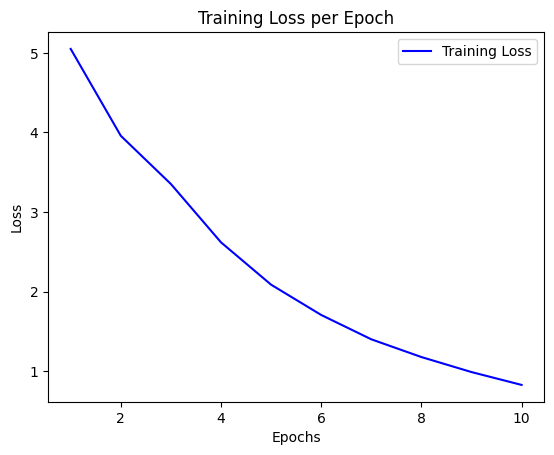

In [37]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

## Step 4: Evaluation Loop
- Set the model to evaluation mode (disables dropout and batch norm).
- Disable gradient computation for inference.
- Loop through the test dataset:
  - Pass the input through the embedding layers.
  - Generate a causal mask for decoding.
  - Compute the model output using the Transformer.
  - Prepare target sequences for loss computation.
  - Compute the test loss without updating weights.
  - Accumulate and store the average test loss.
- Print the final test loss after evaluation.

In [38]:
test_losses = []
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
transformer.eval()
with torch.no_grad():
    test_loss = 0.0
    num_batches = 0

    for batch_idx, (encoder_sequence, decoder_sequence) in enumerate(test_loader):
        x = encoder_embedding(encoder_sequence)
        y = decoder_embedding(decoder_sequence)
        causal_mask = generate_causal_mask(max_sequence_length, y.device)
        out = transformer(x=x, y=y, causal_mask=causal_mask)
        y_input = decoder_sequence[:, :-1]
        y_target = decoder_sequence[:, 1:]
        out_flat = out[:, :-1, :].contiguous().view(-1, decoder_vocab_size)
        y_target_flat = y_target.contiguous().view(-1)
        loss = criterion(out_flat, y_target_flat)
        test_loss += loss.item()
        num_batches += 1

    avg_test_loss = test_loss / num_batches if num_batches > 0 else 0
    test_losses.append(avg_test_loss)
    print(f"🔹 Average Test Loss: {avg_test_loss:.4f}")


🔹 EncoderSequence input shape: torch.Size([32, 10, 512])
🔹 Passing through Encoder Layer 1
===== Encoder Forward Pass =====
🔹 Input Shape: torch.Size([32, 10, 512])
🔹 Processing Multi-Head Attention Layer
🔹 After Attention Layer: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying Dropout1
🔹 After Dropout1: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying LayerNorm1 with Residual Connection
🔹 After Norm1: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Processing FeedForward Layer
🔹 After FeedForward Layer: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 Applying Dropout2
🔹 After Dropout2: Input Shape: torch.Size([32, 10, 512]), Output Shape: torch.Size([32, 10, 512])
🔹 EncoderSequence output shape: torch.Size([32, 10, 512])
🔹 DecoderSequence input shape: torch.Size([32, 10, 512])
🔹 Passing through Decoder Layer 1
===== Decoder Forward Pas

In [43]:
from torchinfo import summary

summary(transformer,verbose=1)

Layer (type:depth-idx)                             Param #
Transformer                                        --
├─EncoderSequence: 1-1                             --
│    └─ModuleList: 2-1                             --
│    │    └─Encoder: 3-1                           7,348,736
├─DecoderSequence: 1-2                             --
│    └─ModuleList: 2-2                             --
│    │    └─Decoder: 3-2                           8,137,728
├─Linear: 1-3                                      1,297,890
Total params: 16,784,354
Trainable params: 16,784,354
Non-trainable params: 0


Layer (type:depth-idx)                             Param #
Transformer                                        --
├─EncoderSequence: 1-1                             --
│    └─ModuleList: 2-1                             --
│    │    └─Encoder: 3-1                           7,348,736
├─DecoderSequence: 1-2                             --
│    └─ModuleList: 2-2                             --
│    │    └─Decoder: 3-2                           8,137,728
├─Linear: 1-3                                      1,297,890
Total params: 16,784,354
Trainable params: 16,784,354
Non-trainable params: 0